
# 第4章: 顧客の行動を予測する 10本ノック

> ## 準備

In [1]:
# フォルダーに移動
% cd /content/drive/My Drive/Colab Notebooks/deeplab/data_analysis_100/

/content/drive/My Drive/Colab Notebooks/deeplab/data_analysis_100


In [2]:
% ls サンプルコード_20200325/4章

4章_顧客の行動を予測する１０本ノック_answer.ipynb  use_log.csv
4章_顧客の行動を予測する１０本ノック.ipynb         use_log_month.csv
customer_join.csv


In [3]:
# 日本語フォント用
!pip install japanize-matplotlib

In [4]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Config
PATH = './サンプルコード_20200325/4章/'

In [7]:
! ls 

 サンプルコード_20200325  'Ch3 (1).ipynb'   Ch5.ipynb	    sample_100knocks
 Ch1.ipynb		   Ch3.ipynb	    dump_data.csv   template.ipynb
 Ch2.ipynb		   Ch4.ipynb	    model.txt


> ## ノック31: データを読み込んで確認しよう

In [8]:
# Chapter 3 で集計したデータを再度インポートする
df_customer_join = pd.read_csv(PATH + 'customer_join.csv')
df_use_log = pd.read_csv(PATH + 'use_log.csv')

In [9]:
# 顧客情報
df_customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaN,CA1,0,ナイト,6000,通常,3.916667,4.0,6,1,1,2019-04-30,47


In [10]:
# 欠損値とデータ数を再確認しておく
print(df_customer_join.isnull().sum())
print(df_customer_join.shape)

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64
(4192, 18)


In [11]:
# ログデータ
df_use_log.head()

,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


In [12]:
print(df_use_log.isnull().sum())
print(df_use_log.shape)

log_id         0
customer_id    0
usedate        0
dtype: int64
(197428, 3)


> ## ノック32:クラスタリングで顧客をグループ化しよう

### メモ：クラスタリング手法
https://scikit-learn.org/stable/modules/clustering.html

In [13]:
# 利用履歴関連のデータから顧客のクラスタリング を行う
df_customer_usage = df_customer_join[['mean', 'median', 'max', 'min', 'membership_period']]
df_customer_usage.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [14]:
# KMeans でクラスタリング 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
num_features = ['mean', 'median', 'max', 'min',  'membership_period']
df_customer_usage[num_features] = sc.fit_transform(df_customer_usage[num_features])
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(df_customer_usage.values)
df_customer_usage['kmeans_cluster'] = clusters.labels_
df_customer_usage['kmeans_cluster'].value_counts()

0    1334
3    1249
2     846
1     763
Name: kmeans_cluster, dtype: int64

In [15]:
! pip install pyclustering

In [16]:
# x-means でもクラスタリング してみる
# x-means が BIC を基準に k-meansの最適なクラスタ数を自動推定してくれる
# https://qiita.com/deaikei/items/8615362d320c76e2ce0b

import pyclustering
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

xm_c = kmeans_plusplus_initializer(df_customer_usage.iloc[:,:-1].values, 2).initialize()  # クラスタ数の初期値は２で設定
xm_i = xmeans(data=df_customer_usage.iloc[:,:-1].values, initial_centers=xm_c, kmax=10, ccore=False)
xm_i.process()

z_xm = np.ones(df_customer_usage.iloc[:,:-1].shape[0])
for k in range(len(xm_i._xmeans__clusters)):
    z_xm[xm_i._xmeans__clusters[k]] = k+1
df_customer_usage['xmeans_cluster'] = z_xm

In [17]:
# 10クラスタに分割された
df_customer_usage['xmeans_cluster'].value_counts()

10.0    796
9.0     746
2.0     539
7.0     498
8.0     423
1.0     380
4.0     291
3.0     262
5.0     225
6.0      32
Name: xmeans_cluster, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe8f18a4518>,
      dtype=object)

<Figure size 1440x1440 with 0 Axes>

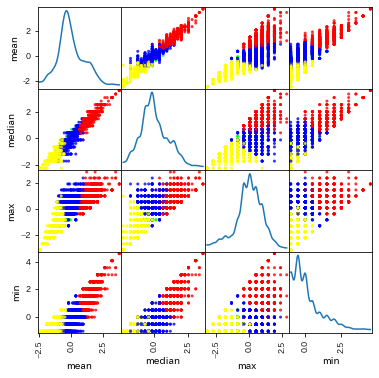

In [18]:
from pandas.plotting import scatter_matrix

# クラスタリング 結果を scatter_matrix で見てみる
# Kmeans から
color_codes = {0:'#0000FF', 1:'#FFFF00', 2:'#FF0000', 3:"#00FF00"}
colors = [color_codes[x] for x in df_customer_usage['kmeans_cluster']]

plt.figure(figsize=(20,20))
scatter_matrix(df_customer_usage[df_customer_usage.columns[:-3]], figsize=(6,6), color=colors, alpha=0.8, diagonal='kde') 

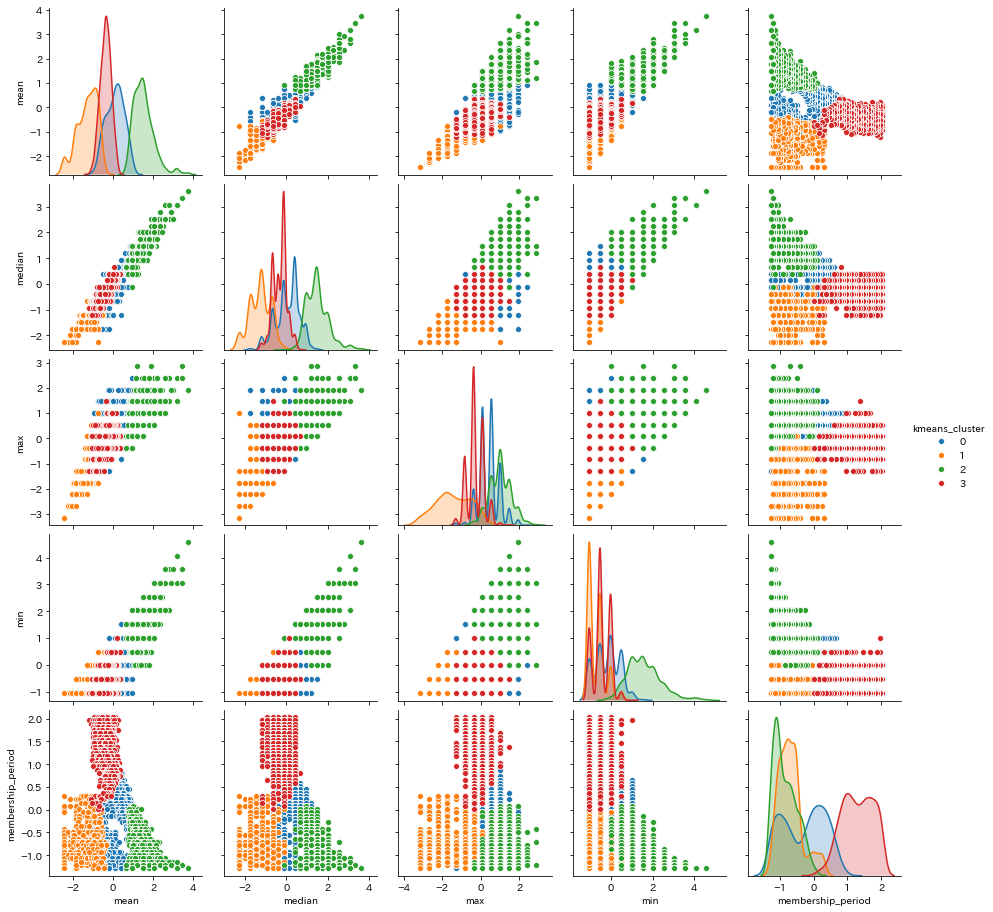

In [20]:
# harukaちゃんから教わった seaborn バージョン
# たしかに見やすい！
df_customer_for_plot = df_customer_usage.copy()
df_customer_for_plot.drop('xmeans_cluster', axis = 1,  inplace=True)
sns.pairplot(data=df_customer_for_plot, hue='kmeans_cluster')


<Figure size 1440x1440 with 0 Axes>

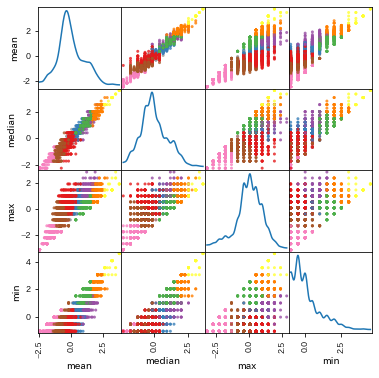

In [21]:
# 一応 X means も見てみる
# kmeansのクラスタが細分化されてるようだけど, プロットだけじゃよくわからない

color_codes = {i:col for i, col in zip(range(1,11), sns.color_palette("Set1", 10))}
colors = [color_codes[x] for x in df_customer_usage['xmeans_cluster']]
plt.figure(figsize=(20,20))
scatter_matrix(df_customer_usage[df_customer_usage.columns[:-3]], figsize=(6,6), color=colors, alpha=0.8, diagonal='kde')   #データのプロット
plt.show()

> ## ノック33:クラスタリング結果を分析しよう

In [22]:
df_customer_usage[['mean', 'median', 'max', 'min', 'membership_period']] = df_customer_join[['mean', 'median', 'max', 'min', 'membership_period']]
df_customer_usage = df_customer_usage.rename(columns = {'mean':'月内平均値', 'median':'月内中央値', 'max':'月内最大値', 'min':'月内最小値', 'membership_period':'会員期間'})

In [23]:
df_customer_usage.groupby('kmeans_cluster').mean()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間,xmeans_cluster
kmeans_cluster,,,,,,
0,5.524239,5.375187,8.745877,2.687406,14.843328,3.889055
1,3.054713,2.888598,4.756225,1.653997,9.263434,7.546527
2,8.054608,8.039598,10.009456,6.160757,7.072104,3.919622
3,4.677494,4.671337,7.232986,2.153723,36.915933,9.613291


- 月内平均だとクラスタ２がダントツ高いが会員期間は短い
- 逆に、会員期間が一番長いクラスタ３は月の利用回数が少なめ
- クラスタ１は月内平均が最も小さく、会員期間も短め

In [24]:
df_customer_usage.groupby('xmeans_cluster').mean()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間,kmeans_cluster
xmeans_cluster,,,,,,
1.0,4.955999,4.500000,9.113158,1.860526,5.415789,0.002632
2.0,6.365582,6.352505,9.176252,3.625232,17.955473,0.189239
3.0,7.522327,7.549618,8.805344,6.194656,5.099237,1.946565
4.0,7.728157,7.690722,10.731959,4.841924,10.123711,1.945017
5.0,8.833974,8.788889,10.377778,7.440000,4.182222,2.000000
6.0,10.875000,10.843750,11.281250,10.500000,1.406250,2.000000
7.0,3.947002,3.700803,6.839357,1.640562,8.939759,0.771084
8.0,2.479152,2.433806,3.300236,1.737589,9.770686,1.000000
9.0,5.246266,5.259383,7.947721,2.521448,28.530831,1.761394


-  xmeansは kmeans の４クラスタを会員期間や月平均を元にさらに細分化しているっぽい

> ## ノック34:クラスタリング結果を可視化しよう

In [25]:
# 主成分分析
# 2成分に次元削除する

from sklearn.decomposition import PCA
X = sc.fit_transform(df_customer_usage.iloc[:,1:5])
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
df_customer_usage[['pca1', 'pca2']] = pd.DataFrame(x_pca)

In [26]:
df_customer_usage.head()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間,kmeans_cluster,xmeans_cluster,pca1,pca2
0,4.833333,5.0,8,2,47,3,10.0,-0.871564,-1.917337
1,5.083333,5.0,7,3,47,3,10.0,-0.822231,-1.743922
2,4.583333,5.0,6,3,47,3,10.0,-1.059209,-1.605403
3,4.833333,4.5,7,2,47,3,10.0,-1.267324,-1.721602
4,3.916667,4.0,6,1,47,3,10.0,-1.949395,-1.560762


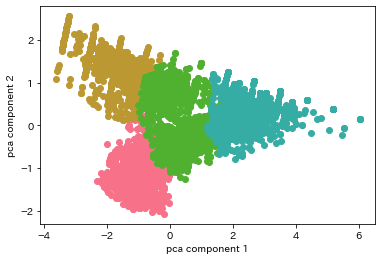

In [27]:
# ２要素でも４クラスタが識別されている
sns.set_palette("husl")
for i in df_customer_usage['kmeans_cluster'].unique():
  cluster_i = df_customer_usage[df_customer_usage['kmeans_cluster']==i]
  plt.scatter(cluster_i['pca1'], cluster_i['pca2'])
plt.xlabel('pca component 1')
plt.ylabel('pca component 2')
plt.show()

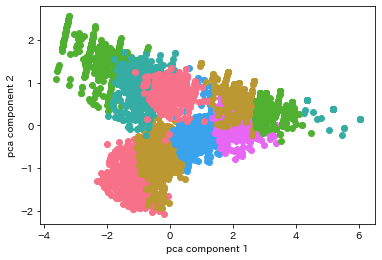

In [28]:
# xmeansの方も見ておく
# 若干識別できていなさそうな箇所がある
sns.set_palette("husl")
for i in df_customer_usage['xmeans_cluster'].unique():
  cluster_i = df_customer_usage[df_customer_usage['xmeans_cluster']==i]
  plt.scatter(cluster_i['pca1'], cluster_i['pca2'])
plt.xlabel('pca component 1')
plt.ylabel('pca component 2')
plt.show()

> ## ノック35:クラスタリング結果をもとに退会ユーザーの傾向を把握しよう

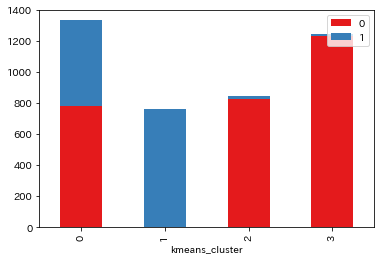

In [29]:
# クラスタごとに退会ユーザーの分布をみてみる
sns.set_palette("Set1")
df_customer_usage['is_deleted'] = df_customer_join['is_deleted']
df_stacked = df_customer_usage.groupby(['kmeans_cluster', 'is_deleted']).size().unstack(1)
df_stacked.plot(kind='bar', stacked=True)
plt.legend(loc = 'upper right')
plt.show()

- クラスタ１は退会者で占められている. 
- クラスタ0は半々というところ
- 逆にクラスタ２、３は継続者で占められている

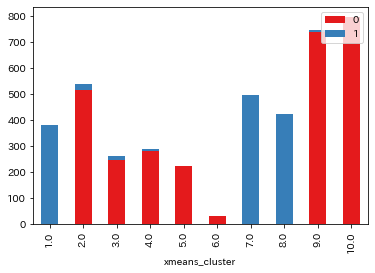

In [30]:
# x means の方も見てみる
sns.set_palette("Set1")
df_stacked = df_customer_usage.groupby(['xmeans_cluster', 'is_deleted']).size().unstack(1)
df_stacked.plot(kind='bar', stacked=True)
plt.legend(loc = 'upper right')
plt.show()

- xmeans はクラスタ数が多いものの、退会者をしっかり分類できているよう


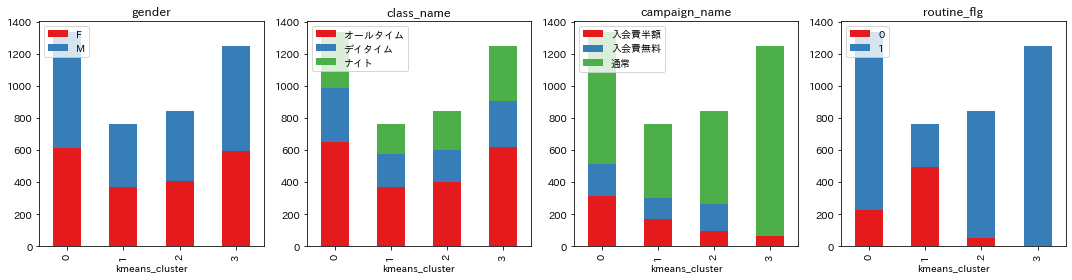

In [31]:
# とりあえず、クラスタごとに cusomter_join 属性関係の分布を再度可視化してみる
features_to_plot = ['gender', 'class_name', 'campaign_name', 'routine_flg']
df_customer_usage[features_to_plot] = df_customer_join[features_to_plot]
fig, axis = plt.subplots(1, 4, figsize=(15, 4))
i = 0
for feature in features_to_plot:
  df_stacked = df_customer_usage.groupby(['kmeans_cluster', feature]).size().unstack(1)
  df_stacked.plot(kind='bar', stacked=True, ax=axis[i])
  axis[i].set_title(feature)
  axis[i].legend(loc = 'upper left')
  i+=1
plt.tight_layout()
plt.show()

- 性別の差はなさそう
- クラス(class name) もはっきりとした差はない
- キャンペーン中入会者はクラスタ0, 1, 2に多い(得に0) → 退会に影響していることが確認できる　
- 不定期な利用者が１に集まっている. → ２つ前のグラフからも退会者に強く現れている特徴と確認できる

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


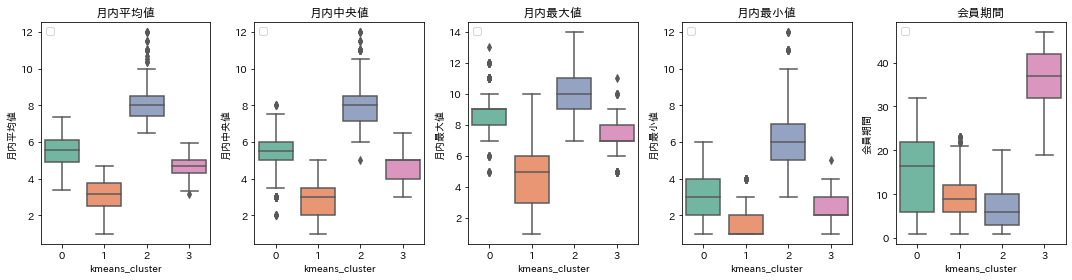

In [32]:
# 履歴情報も確認してみる
features_to_plot = ['月内平均値', '月内中央値', '月内最大値', '月内最小値', '会員期間']
fig, axis = plt.subplots(1, 5, figsize=(15, 4))
i = 0
for feature in features_to_plot:
  sns.boxplot(x='kmeans_cluster', y=feature, data=df_customer_usage, palette='Set2', ax=axis[i])
  axis[i].set_title(feature)
  axis[i].legend(loc = 'upper left')
  i+=1
plt.tight_layout()
plt.show()

#### 考察
- 退会者が多いクラスタ１は利用回数が少なく、会員期間も短めで、定期的な利用が少ない
- 継続者が多い３は長期会員で、利用回数は多くないものの定期的利用がある
- 継続者が次に多い２は、会員期間は短いものの、月平均が多く定期的な利用傾向にある為、新規の極的な会員が多いと考えられる


> ## ノック36:翌月の利用回数予測を行うためのデータ準備をしよう

In [33]:
# 時系列慣れていないので、本を参考に進めます
# まずは日付を年月に直します

df_use_log['usedate'] = pd.to_datetime(df_use_log['usedate'])
df_use_log['年月'] = df_use_log['usedate'].dt.strftime('%Y%m')
df_use_log_month = df_use_log.groupby(['年月', 'customer_id'], as_index=False).count()
df_use_log_month.rename(columns={'log_id':'count'}, inplace=True)
del df_use_log_month['usedate']
df_use_log_month.head()

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [34]:
# ６ヶ月間のデータから予測する
# 2018年6月~10月 + 11月を学習データに利用する

year_months_list = list(df_use_log['年月'].unique())
data_predict = pd.DataFrame()
# データが残っている最初の６ヶ月間は使えないので, 6からループを回します
for i in range(6, len(year_months_list)):
  tmp = df_use_log_month[df_use_log_month['年月']==year_months_list[i]]
  tmp.rename(columns={'count':'count_pred'}, inplace=True)
  # その時点から過去６ヶ月分の各月の利用回数を格納
  for j in range(1, 7):
    tmp_before = df_use_log_month[df_use_log_month['年月']==year_months_list[i-j]]
    del tmp_before['年月']
    tmp_before.rename(columns={'count':'count_{}'.format(j-1)},inplace=True)
    tmp = pd.merge(tmp, tmp_before, on='customer_id', how='left')
  data_predict = pd.concat([data_predict, tmp], ignore_index=True)

data_predict.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


In [35]:
data_predict.shape

(18310, 9)

In [36]:
# 欠損があるので削除する
data_predict = data_predict.dropna(axis=0)
data_predict = data_predict.reset_index(drop=True)
data_predict.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


In [37]:
data_predict.shape

(15113, 9)

In [38]:
data_predict.isna().sum()

年月             0
customer_id    0
count_pred     0
count_0        0
count_1        0
count_2        0
count_3        0
count_4        0
count_5        0
dtype: int64

> ## ノック37:特徴となる変数を付与しよう

In [39]:
# 各年月と開始月との差分を追加する

data_predict = pd.merge(data_predict, df_customer_join[['customer_id', 'start_date']], on='customer_id', how='left')
data_predict['present_date'] = pd.to_datetime(data_predict['年月'], format='%Y%m')
data_predict['start_date'] = pd.to_datetime(data_predict['start_date'])

from dateutil.relativedelta import relativedelta

# Converts relative delta to months
def delta_to_months(x):
  return x.years*12 + x.months


data_predict['user_period'] = None
data_predict['user_period'] = data_predict.apply(lambda x: delta_to_months(relativedelta(x['present_date'], x['start_date'])), axis=1)
data_predict.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,present_date,user_period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


> ## ノック38:来月の利用回数予測モデルを作成しよう


In [40]:
data_predict.dtypes

年月                      object
customer_id             object
count_pred               int64
count_0                float64
count_1                float64
count_2                float64
count_3                float64
count_4                float64
count_5                float64
start_date      datetime64[ns]
present_date    datetime64[ns]
user_period              int64
dtype: object

In [41]:
# 2018年4月以降に入会した客はデータが少ない為使用しない
# 学習用とテスト用にデータの分割
import sklearn.model_selection

data_predict = data_predict.loc[data_predict['start_date']>=pd.to_datetime("20180401")]
X = data_predict[['count_0', 'count_1', 'count_2', 'count_3', 'count_4', 'count_5', 'user_period']]
y = data_predict['count_pred']


X_trainval, X_test,  y_trainval, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)
X_train, X_valid,  y_train, y_valid  = sklearn.model_selection.train_test_split(X_trainval, y_trainval, test_size=0.1)



In [56]:
# LightGBMで学習+予測

import lightgbm as lgb
from sklearn.metrics import mean_squared_error,r2_score

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid)

evaluation_results = {}
params = {
    'objective' : 'regression',
    'max_bin'   : 200,
    'max_depth' : 4,
    'num_leaves': 23,
    'verbose':0,
    'learning_rate':0.1,
}

model = lgb.train(train_set=lgb_train,
                 params=params,
                 #valid_sets=lgb_eval, 
                 early_stopping_rounds=100,
                 verbose_eval=50,
                valid_sets=[lgb_train, lgb_eval], 
                valid_names=['Train', 'Test'],
                evals_result=evaluation_results,
                )
optimum_boost_rounds = model.best_iteration

y_trainval_pred = model.predict(X_trainval, num_iteration=model.best_iteration)
y_test_pred = model.predict(X_test, num_iteration=model.best_iteration)

# R2で評価
r2_trainval = r2_score(y_trainval, y_trainval_pred)
r2_test = r2_score(y_test, y_test_pred)

print("r2_train:{0:.4}".format(r2_trainval))
print("r2_test:{0:.4}".format(r2_test))

Training until validation scores don't improve for 100 rounds.
[50]	Train's l2: 2.03812	Test's l2: 2.21071
[100]	Train's l2: 1.86445	Test's l2: 2.21885
Did not meet early stopping. Best iteration is:
[100]	Train's l2: 1.86445	Test's l2: 2.21885
r2_train:0.7317
r2_test:0.6472


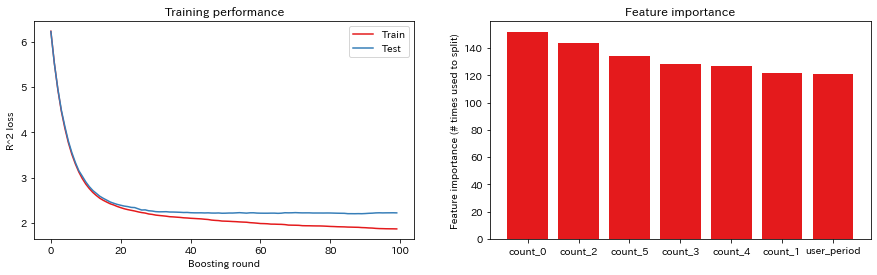

In [60]:
# Plot the log loss during training
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

axs[0].plot(evaluation_results['Train']['l2'], label='Train')
axs[0].plot(evaluation_results['Test']['l2'], label='Test')
axs[0].set_ylabel('R^2 loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': model.feature_name(), 
                            'importance': model.feature_importance()}).sort_values('importance', ascending=False)

axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'])
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')

plt.show()

> ## ノック39:モデルに寄与している変数を確認しよう


In [43]:
# feature importanceを確認

fti = model.feature_importance()
i = 0
df_feat_importance = {}
for feat in enumerate(X.columns):
    df_feat_importance[feat[1]] = fti[i]
    i+=1
df_feat_importance = pd.DataFrame(list(zip(df_feat_importance.keys(), df_feat_importance.values())), columns=['feature', 'importance_score'])
df_feat_importance.sort_values(by='importance_score', ascending=False)

,feature,importance_score
2,count_2,135
0,count_0,134
5,count_5,118
3,count_3,114
6,user_period,113
1,count_1,111
4,count_4,104


- 直近のデータが強くでるはず、、、若干順番が前後しているのはなぜだろう

> ## ノック40:来月の利用回数を予測しよう

In [44]:
# 教科書と同じので試してみる
xl = [3,4,4,6,8,7,8]
x2 = [2, 2, 3, 3, 4, 6, 8]
x_pred = [xl, x2]
model.predict(x_pred )  

array([3.42944873, 2.3416702 ])

In [45]:
# データを保存しておく
df_use_log_month.to_csv(PATH+'use_log_month.csv', index=False)